In [2]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from TerrainMesh.utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from TerrainMesh.vis.vis import pseudo_color_map, pseudo_color_map_sparse

import torch
import torch.nn as nn
from torchvision import transforms
from TerrainMesh.config import get_sensat_cfg

import plotly.graph_objects as go
import numpy as np 
from TerrainMesh.mesh_init.mesh_init_linear_solver import init_mesh_sparse
from TerrainMesh.mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from TerrainMesh.vis.vis import texture_mesh_vertices

import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from TerrainMesh.model.models import VoxMeshHead

from TerrainMesh.mesh_init.mesh_renderer import render_mesh_texture

import meshplot as mp
import cv2
from skimage.transform import resize
import random
import trimesh

# ========================
# ESANet
# ========================

import argparse
from glob import glob
import os
from ESANet.src.args import ArgumentParserRGBDSegmentation
from ESANet.src.build_model import build_model
from ESANet.src.prepare_data import prepare_data

import torch.nn.functional as F

import open3d as o3d
from TerrainMesh.vis.vis import texture_mesh

# ========================
# FUNCTION DEFINITIONS
# ========================

def rescale_mesh(mesh, original_min, original_max):
    z_vals = np.asarray(mesh.vertices)[:,2]
    z_vals_scaled = ((z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))) * (original_max - original_min) + original_min
    vertices_scaled = np.asarray(mesh.vertices).copy()
    vertices_scaled[:,2] = z_vals_scaled
    mesh.vertices = o3d.utility.Vector3dVector(vertices_scaled)
    return mesh

def make_mesh(vertices, faces, smooth=True, its=5):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    if smooth:
        mesh = mesh.filter_smooth_simple(number_of_iterations=its)
    return mesh


def export_obj(vertices, faces, filepath):
    with open(filepath, 'w') as f:
        # Write vertices
        x_max = float('-inf')
        x_min = float('inf')
        y_max = float('-inf')
        y_min = float('inf')
        for vertex in vertices:
            f.write(f"v {' '.join(map(str, vertex))}\n")
            x_max = max(x_max, vertex[0])
            x_min = min(x_min, vertex[0])
            y_max = max(y_max, vertex[1])
            y_min = min(y_min, vertex[1])

        # Write faces
        for face in faces:
            f.write("f")
            for vertex_index in face:
                vi = vertex_index + 1
                f.write(f" {vi}")  # OBJ format indices are 1-based
            f.write("\n")

# Get the unique colors
CLASS_NAMES_13 = ['void',
                      'bed', 'books', 'ceiling', 'chair', 'floor', 'furniture',
                      'objects', 'picture', 'sofa', 'table', 'tv', 'wall',
                      'window']
CLASS_NAMES_40 = ['void',
                  'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
                  'table', 'door', 'window', 'bookshelf', 'picture',
                  'counter', 'blinds', 'desk', 'shelves', 'curtain',
                  'dresser', 'pillow', 'mirror', 'floor mat', 'clothes',
                  'ceiling', 'books', 'refridgerator', 'television',
                  'paper', 'towel', 'shower curtain', 'box', 'whiteboard',
                  'person', 'night stand', 'toilet', 'sink', 'lamp',
                  'bathtub', 'bag',
                  'otherstructure', 'otherfurniture', 'otherprop']

CLASS_NAMES_5 = ['wall', 'floor', 'furniture', 'objects', 'ceiling']

CLASS_13_TO_5_MAP = {
    'void': 'wall',
    'bed': 'furniture',
    'books': 'objects',
    'ceiling': 'ceiling',
    'chair': 'furniture',
    'floor': 'floor',
    'furniture': 'furniture',
    'objects': 'objects',
    'picture': 'objects',
    'sofa': 'furniture',
    'table': 'furniture',
    'tv': 'furniture',
    'wall': 'wall',
    'window': 'wall',
}

CLASS_13_TO_IDX_MAP = {}
for idx, c in enumerate(CLASS_NAMES_13):
    CLASS_13_TO_IDX_MAP[c] = idx

CLASS_5_TO_IDX_MAP = {}
for idx, c in enumerate(CLASS_NAMES_5):
    CLASS_5_TO_IDX_MAP[c] = idx

CLASS_40_TO_13_MAP = {
    'void': 'void',
    'wall': 'wall',
    'floor': 'floor',
    'cabinet': 'furniture',
    'bed': 'bed',
    'chair': 'chair',
    'sofa': 'sofa',
    'table': 'table',
    'door': 'wall',
    'window': 'window',
    'bookshelf': 'furniture',
    'picture': 'picture',
    'counter': 'furniture',
    'blinds': 'wall',
    'desk': 'table',
    'shelves': 'furniture',
    'curtain': 'wall',
    'dresser': 'furniture',
    'pillow': 'objects',
    'mirror': 'objects',
    'floor mat': 'floor',
    'clothes': 'objects',
    'ceiling': 'ceiling',
    'books': 'books',
    'refridgerator': 'furniture',
    'television': 'tv',
    'paper': 'objects',
    'towel': 'objects',
    'shower curtain': 'objects',
    'box': 'objects',
    'whiteboard': 'objects',
    'person': 'objects',
    'night stand': 'furniture',
    'toilet': 'furniture',
    'sink': 'furniture',
    'lamp': 'objects',
    'bathtub': 'furniture',
    'bag': 'objects',
    'otherstructure': 'wall',
    'otherfurniture': 'furniture',
    'otherprop': 'objects',
}

CLASS_40_13_IDX_MAP = []
for c in CLASS_NAMES_40:
    CLASS_40_13_IDX_MAP.append(CLASS_13_TO_IDX_MAP[CLASS_40_TO_13_MAP[c]])
# CLASS_40_13_IDX_MAP = np.array(CLASS_40_13_IDX_MAP)
# print(CLASS_40_13_IDX_MAP)
CLASS_40_13_IDX_MAP = torch.tensor(CLASS_40_13_IDX_MAP)

CLASS_13_5_IDX_MAP = []
for c in CLASS_NAMES_13:
    CLASS_13_5_IDX_MAP.append(CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[c]])
# CLASS_13_5_IDX_MAP = np.array(CLASS_13_5_IDX_MAP)
# print(CLASS_13_5_IDX_MAP)
CLASS_13_5_IDX_MAP = torch.tensor(CLASS_13_5_IDX_MAP)

def class_to_rgb_indoor(img_class):
    class_color_map = {
        0:(51, 158, 133), #wall 
        1:(200,200,200), #floor
        2:(179, 245, 229), #furniture
        3:(247, 52, 143), #objects
        4:(114, 192, 247), #ceiling
    }
    h, w = img_class.shape
    img_rgb = np.zeros((h,w,3))
    for classlabel, color in class_color_map.items():
        binary_mask = (img_class == classlabel)
        img_rgb[binary_mask,:] = color 
    return img_rgb.astype(np.uint8)

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

parser = ArgumentParserRGBDSegmentation(
    description='Efficient RGBD Indoor Sematic Segmentation (Inference)',
    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.set_common_args()
parser.add_argument('--ckpt_path', type=str,
                    default="ESANet/trained_models/scenenet/r34_NBt1D_scenenet.pth",
                    help='Path to the checkpoint of the trained model.')
parser.add_argument('--depth_scale', type=float,
                    default=1.0,
                    help='Additional depth scaling factor to apply.')
args, _ = parser.parse_known_args()

args.pretrained_on_imagenet = False  # we are loading other weights anyway
dataset, preprocessor = prepare_data(args, with_input_orig=True)

n_classes = dataset.n_classes_without_void

model_semantic, _ = build_model(args, n_classes=n_classes)
checkpoint = torch.load(args.ckpt_path,
                        map_location=lambda storage, loc: storage)
model_semantic.load_state_dict(checkpoint['state_dict'])

model_semantic.eval()
model_semantic.to(device)


save_model_path = "TerrainMesh/checkpoints/Sem_Dice/model_best_depth.tar"
# device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Loaded NYUv2 dataset without files
Loaded NYUv2 dataset without files
Device: cuda:0
ESANet(
  (activation): ReLU(inplace=True)
  (encoder_rgb): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): NonBottleneck1D(
        (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (conv3x1_2): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (conv1x3_2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (bn2): 

VoxMeshHead(
  (backbone): ResNetBackbone(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (stem): Sequential(
      (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3,

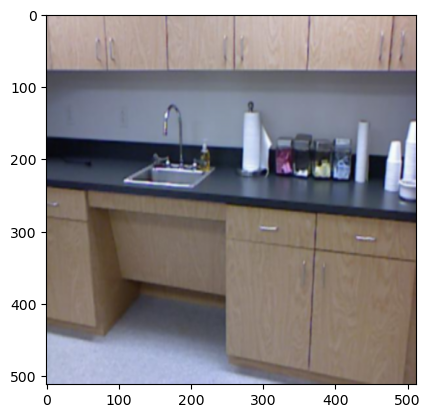

In [3]:
n = 163
nyu_rgb = np.load(f"nyuv2_dataset/rgb/{n}.npy")
plt.imshow(nyu_rgb)

In [10]:
depth_scale = 1.0
depth_min = 50
depth_max = 600

num_mesh_vertices = 1024
image_size = 512
focal_length = -2

def remap(arr, low, high):
    return ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) * (high-low) + low

def dice_loss(y_true, y_pred, num_classes):
    dice_per_class = np.zeros(num_classes, dtype=np.float32)
    
    for c in range(num_classes):
        true_match = y_true == c
        pred_match = y_pred == c
        intersection = np.sum(true_match & pred_match)
        total_true = np.sum(true_match)
        total_pred = np.sum(pred_match)
        dice_per_class[c] = 2. * intersection / (total_true + total_pred + 1e-6)  # Add epsilon to avoid division by zero
    
    return dice_per_class

def compute_iou(y_true, y_pred, num_classes):
    iou_per_class = np.zeros(num_classes, dtype=np.float32)
    
    for c in range(num_classes):
        intersection = np.sum((y_true == c) & (y_pred == c))
        union = np.sum((y_true == c) | (y_pred == c))
        iou_per_class[c] = intersection / (union + 1e-6)  # Add epsilon to avoid division by zero
    
    return iou_per_class

initial_losses = []
refined_losses = []
dice_losses = []

for i in range(1, 20):
    nyu_rgb = np.load(f"nyuv2_dataset/rgb/{n}.npy")
    nyu_sparse_depth = np.load(f"nyuv2_dataset/sparse_depth/{n}.npy")
    nyu_depth = np.load(f"nyuv2_dataset/gt_depth/{n}.npy")
    nyu_label = np.load(f"nyuv2_dataset/semantic/{n}.npy").astype(int)
    
    rgb = nyu_rgb
    
    sparsedepth = np.squeeze(nyu_sparse_depth)/.01
    nonzero_indices = sparsedepth != 0
    nonzero_values = sparsedepth[nonzero_indices]
    mapped_values = remap(nonzero_values, 250, 300)
    sparsedepth[nonzero_indices] = mapped_values
    
    gt_depth = np.squeeze(nyu_depth)/.01
    
    nyu_label_5 = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_NAMES_13[idx]]])(nyu_label + 1)
    gt_sem_vis = class_to_rgb_indoor(nyu_label_5)
    
    sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
    gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
    
    original_max = np.max(nonzero_values)
    original_min = np.min(nonzero_values)
    
    # =================================
    # MESH INITIALIZATION
    # =================================
    
    # Initialize the mesh using only the sparse depth
    init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
    init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
    init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
    init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])
    
    init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
    
    # =================================
    # SEMANTIC SEGMENTATION
    # =================================
    h, w, _ = rgb.shape
    
    # preprocess sample
    sample = preprocessor({'image': rgb, 'depth': init_mesh_depth})
    
    # add batch axis and copy to device
    image = sample['image'][None].to(device)
    depth = sample['depth'][None].to(device)
    
    # apply network
    pred = model_semantic(image, depth)
    pred_semantic_weights = F.interpolate(pred, (h, w),
                         mode='bilinear', align_corners=False)
    
    pred_semantic = torch.argmax(pred_semantic_weights, dim=1)
    pred_semantic = pred_semantic.cpu().numpy().squeeze().astype(np.uint8)
    
    pred_semantic = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_40_TO_13_MAP[CLASS_NAMES_40[idx]]]])(pred_semantic+1)
    pred_semantic_features = F.one_hot(torch.tensor(pred_semantic+1), num_classes=5)
    
    # Add batch dimension to the one-hot tensor
    pred_semantic_features = pred_semantic_features.unsqueeze(0).permute(0, 3, 1, 2).to(torch.float32) * 5
    pred_semantic_features = pred_semantic_features.to(device)
    
    # =================================
    # MESH REFINEMENT
    # =================================
    
    # Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
    rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
    init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
    sparsedepth_mask = (sparsedepth<=0)*1
    depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
    depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
    input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)
    
    # Normalized the mesh
    init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
    init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
    init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])
    
    # The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
    refine_mesh = model(input_img, init_mesh, pred_semantic_features)
    refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))
    
    refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
    # refine_mesh_semantic = np.vectorize(lambda idx: CLASS_5_TO_IDX_MAP[CLASS_13_TO_5_MAP[CLASS_40_TO_13_MAP[CLASS_NAMES_40[idx]]]])(refine_mesh_semantic)
    
    # refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
    # refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
    # refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()

    gathered_gt = gt_depth[nonzero_indices]
    
    gathered_init = init_mesh_depth[nonzero_indices]
    gathered_init = remap(gathered_init, original_min, original_max)
    l2_loss_init = np.mean(np.abs(gathered_gt - gathered_init))
    initial_losses.append(l2_loss_init)

    gathered_refined = refine_mesh_depth[nonzero_indices]
    gathered_refined = remap(gathered_refined, original_min, original_max)
    l2_loss_refined = np.mean(np.abs(gathered_gt - gathered_refined))
    refined_losses.append(l2_loss_refined)

    # DICE LOSS:
    semantic_loss = dice_loss(nyu_label_5, pred_semantic, 5)
    dice_losses.append(semantic_loss)

    iou_score = compute_iou(nyu_label_5, pred_semantic, 5)

    if (i % 1 == 0):
        print(i, l2_loss_init, l2_loss_refined)
        print(i, semantic_loss)
        print(i, iou_score)


1 13.654426 60.31465
1 [0.53207225 0.         0.78411597 0.7566908  0.        ]
1 [0.36246487 0.         0.64489377 0.60861033 0.        ]
2 13.7971 60.271698
2 [0.53191704 0.         0.7840958  0.7580649  0.        ]
2 [0.36232084 0.         0.64486647 0.6103901  0.        ]
3 16.240797 59.837734
3 [0.53244436 0.         0.7846704  0.75859714 0.        ]
3 [0.3628103 0.        0.6456441 0.6110805 0.       ]
4 16.030567 59.656006
4 [0.53174394 0.         0.7835751  0.75877696 0.        ]
4 [0.36216024 0.         0.64416236 0.61131394 0.        ]
5 16.07418 60.019085
5 [0.53162307 0.         0.78370833 0.7576812  0.        ]
5 [0.3620481  0.         0.6443424  0.60989267 0.        ]
6 13.809154 60.36905
6 [0.5317604  0.         0.78384614 0.7580094  0.        ]
6 [0.3621755 0.        0.6445288 0.6103181 0.       ]
7 16.250282 59.846817
7 [0.532411   0.         0.7846928  0.75884795 0.        ]
7 [0.36277935 0.         0.6456745  0.6114061  0.        ]
8 16.03046 59.655853
8 [0.53174394 

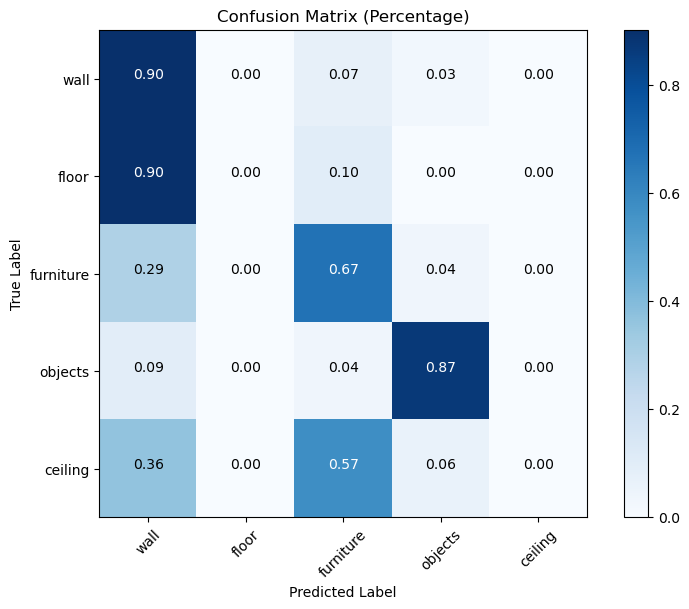

In [18]:
import random



def plot_confusion_matrix(y_true, y_pred, num_classes, class_names):
    """
    Compute and plot confusion matrix as a heatmap.

    Args:
    - y_true: Ground truth labeled image (NumPy 2D array).
    - y_pred: Predicted labeled image (NumPy 2D array).
    - num_classes: Number of classes including background.
    - class_names: List of class names.
    """
    # Compute confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true_label in range(num_classes):
        for pred_label in range(num_classes):
            confusion_matrix[true_label, pred_label] = np.sum((y_true == true_label) & (y_pred == pred_label))

    # Normalize confusion matrix to show percentages
    row_sums = confusion_matrix.sum(axis=1)
    norm_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(norm_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Percentage)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = norm_confusion_matrix.max() / 2.
    for i in range(norm_confusion_matrix.shape[0]):
        for j in range(norm_confusion_matrix.shape[1]):
            val = norm_confusion_matrix[i, j]
            plt.text(j, i, format(val, fmt),
                     horizontalalignment="center",
                     color="white" if norm_confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(nyu_label_5, pred_semantic, 5, CLASS_NAMES_5)
